# Rusty Bargain

## Introduction

**Background**

Rusty Bargain, a leading used car sales service, is developing a new mobile application aimed at attracting prospective customers. The app's primary feature is the ability to swiftly determine the market value of a user's car. To achieve this, the project requires building a machine learning model capable of accurately predicting car values based on historical data encompassing technical specifications, trim versions, and past prices.

**Objectives**
The project focuses on three key objectives:
* Prediction Quality: Develop a model that reliably estimates car market values, ensuring users receive accurate and dependable information.
* Prediction Speed: Optimize the prediction process for rapid valuation, enhancing user experience within the Rusty Bargain app.
* Training Efficiency: Streamline model training to minimize time and computational resources while maintaining high prediction accuracy.

**Data Description**
The dataset includes detailed technical specifications, trim variations, and historical pricing data for multiple car models. This data forms the basis for training and evaluating the machine learning model.

**Methodology**
The approach involves exploring various machine learning algorithms suitable for regression tasks, evaluating their performance metrics, and refining the chosen model to meet Rusty Bargain’s rigorous standards for prediction accuracy, speed, and efficiency.

**Project Scope**
This project aims to deliver a scalable and robust machine learning solution integrated into the Rusty Bargain app. By leveraging advanced machine learning techniques and optimizing computational efficiency, the goal is to provide an exceptional car valuation service that enhances customer engagement and satisfaction.

## Setup

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import math
import pprint
import time
import sklearn.linear_model
import sklearn.tree
import sklearn.ensemble
import sklearn.metrics

from scipy import stats as st
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

### Data Import

In [2]:
try:
    data = pd.read_csv('./data/car_data.csv')
except FileNotFoundError as e:
    print(f'The following error occured: {e}')
else:
    print('The data was loaded successfully.')

The data was loaded successfully.


## Data Preparation

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


**Observations**

The initial analysis of the dataset indicates that the column names are not appropriately labeled. Furthermore, the data types for certain features are unusual and warrant further investigation. Additionally, there are significant missing values in the `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `NotRepaired` columns, all of which could be crucial for determining market value. These issues need to be examined, and a suitable method for addressing the missing values must be determined.

Additionally, some values in the dataset do not make sense. For instance, the `power` feature has some values of 0, which is unrealistic since vehicles cannot have zero horsepower. These values will be replaced with the mean to ensure more accurate results when evaluating models.

In [5]:
# Fix column names

new_column_names = []
for col in data.columns:
    new_column_names.append(''.join(['_' + i.lower() if i.isupper() else i for i in col]).lstrip('_'))

data.columns = new_column_names

In [6]:
# Find number of missing values

print("----------Number of Missing Values by Column----------\n")
for col in data.columns:
    missing_count = data[col].isna().sum()
    if missing_count > 0:
        print(f"{col}: {missing_count}")
        print(data[col].value_counts(), '\n')
        print("========================================================================")

----------Number of Missing Values by Column----------

vehicle_type: 37490
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64 

gearbox: 19833
manual    268251
auto       66285
Name: gearbox, dtype: int64 

model: 19705
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
serie_3                   4
rangerover                4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64 

fuel_type: 32895
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64 

not_repaired: 71154
no     247161
yes     36054
Name: not_repaired, dtype: int64 



The number of missing values is notably high, particularly in the `not_repaired`, `fuel_type`, and `vehicle_type` columns. The following methods will be used to handle the missing values:

* `vehicle_type`: Missing values will be categorized as 'other'.
* `gearbox`: Missing values will be set to 'manual' since 'manual' values significantly outnumber 'automatic' * values.
* `model`: Missing values will be filled with the most frequent value.
* `fuel_type`: Missing values will be assigned 'unknown'.
* `not_repaired`: Missing values will be classified as 'no', as it is more prudent to assume they were not repaired rather than assuming they were.

In [7]:
# Fill missing values -- vehicle_type

data['vehicle_type'].fillna('other', inplace=True)
data['gearbox'].fillna('manual', inplace=True)
data['model'].fillna(data['model'].mode()[0], inplace=True)
data['fuel_type'].fillna('unknown', inplace=True)
data['not_repaired'].fillna('no', inplace=True)

In [8]:
# Ensure missing values are replaced

data.loc[:, ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired']].isna().sum()

vehicle_type    0
gearbox         0
model           0
fuel_type       0
not_repaired    0
dtype: int64

In [9]:
# Replace `power` values of 0 with the mean

data['power'].replace(0, math.ceil(data['power'].mean()), inplace=True)

In [10]:
# Find number of duplicates

data.duplicated().sum()

293

Although there are duplicates within the dataset, they do not need to be removed or handled. This is because the same values can appear more than once without indicating duplicate entries. For example, it is possible for two vehicles to share the same mileage, brand, fuel type, etc.

In [11]:
# Observe data

data.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,other,1993,manual,111,golf,150000,0,petrol,volkswagen,no,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,no,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,no,17/03/2016 00:00,0,27472,31/03/2016 17:17


## Model Training

### Data Preprocessing

In [12]:
# Data split function

def get_data_split(data, split_size=0.40, rnd_state=12345, shuffle=True):
    
    # Split the data into train and validation
    data_train, data_valid = train_test_split(
        data, test_size=split_size, shuffle=True, random_state=rnd_state
    )
    
    # Further split the validation set in half to obtain test test
    data_test, data_valid = train_test_split(
        data_valid, test_size=(split_size + .10), shuffle=True, random_state=rnd_state
    )
    
    # Handle potential errors & print summary of data split
    try:
        sum_of_datasets = len(data_train) + len(data_valid) + len(data_test)
        if len(data) == sum_of_datasets:
            print(
                'Data Split Ratio (3:1:1)\n',  
                f' Train = 60% [shape={data_train.shape}]\n', 
                f' Validation = 20% [shape={data_valid.shape}]\n',
                f' Test = 20% [shape={data_test.shape}]'
            )
        else:
            raise ValueError("Data lengths do not match expected sum.")
    except ValueError as ve:
            print(f"ValueError: {ve}")
    except Exception as e:
            print(f"Error when splitting data: {e}")
        
    # Return split datasets
    return data_train, data_valid, data_test

In [13]:
# Function to define features and targets for particular dataset

def get_features_and_target(data, target_column):
    """
    Function to separate features and target from a dataset.
    
    Parameters:
    - data: DataFrame, the dataset containing both features and target.
    - target_column: str, the name of the target column in the DataFrame.
    
    Returns:
    - X: DataFrame, features (all columns except the target column).
    - y: Series, target (selected target column).
    """
    
    X = data.drop(columns=[target_column])
    y = data[target_column]
    
    return X, y

In [14]:
# Remove features unncessary for model training

data_f = data.drop(
    ['date_crawled', 'date_created', 'last_seen', 'postal_code', 'number_of_pictures', 'registration_month']
    , axis=1
)

In [15]:
# Perform OHE 

data_f_encoded = pd.get_dummies(data_f, drop_first=True)

In [16]:
# Split the data

train_data_encoded, valid_data_encoded, test_data_encoded = get_data_split(
    data_f_encoded, split_size=0.40, rnd_state=12345, shuffle=True
)

Data Split Ratio (3:1:1)
  Train = 60% [shape=(212621, 307)]
  Validation = 20% [shape=(70874, 307)]
  Test = 20% [shape=(70874, 307)]


In [17]:
# Declare features & target for all three datasets

X_train_encoded, y_train = get_features_and_target(train_data_encoded, 'price')
X_valid_encoded, y_valid = get_features_and_target(valid_data_encoded, 'price')
X_test_encoded, y_test = get_features_and_target(test_data_encoded, 'price')

### Baseline Model

In [32]:
%%time

# Train and evaluate baseline model
model = sklearn.linear_model.LinearRegression()

# Fit model to training data
model.fit(X_train_encoded, y_train)

# Predict on validation data
y_valid_pred = model.predict(X_valid_encoded)

# Calculate RMSE for validation predictions
linear_rmse = sklearn.metrics.mean_squared_error(y_valid, y_valid_pred, squared=False)
best_linear_model = model

print(f'Baseline Linear Regression RMSE: {linear_rmse}\n')

Baseline Linear Regression RMSE: 3292.5105069634646

CPU times: user 13.5 s, sys: 3.95 s, total: 17.5 s
Wall time: 17.5 s


### Decision Tree Model

In [27]:
%%time

# Train and evaluate tree regressor model
best_tree_model = None
tree_rmse = float('inf')


print('Tree Regression RMSE:')

# Loop through depths from 1 to 20
for depth in range(1, 22, 5):
    # Initialize Decision Tree Regressor with specified depth and random state
    model = sklearn.tree.DecisionTreeRegressor(random_state=12345, max_depth=depth)
    
    # Train the model on encoded training data
    model.fit(X_train_encoded, y_train)
    
    # Predict using the trained model on encoded validation data
    y_valid_pred = model.predict(X_valid_encoded)
    
    # Calculate RMSE between predicted and actual validation targets
    rmse = sklearn.metrics.mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    # Saving the best model
    if rmse < tree_rmse:
        tree_rmse = rmse
        best_tree_model = model
    
    # Print depth and corresponding RMSE
    print(f'depth {depth}: RMSE = {rmse}')

print()

Tree Regression RMSE:
depth 1: RMSE = 3803.142525805641
depth 6: RMSE = 2419.5521674678084
depth 11: RMSE = 2128.677051179106
depth 16: RMSE = 2042.251067036347
depth 21: RMSE = 2072.52106168683

CPU times: user 22.5 s, sys: 732 ms, total: 23.2 s
Wall time: 23.2 s


### Random Forest Model

In [29]:
%%time

# Train and evaluate random forest regressor model at depth = 15

best_forest_model = None
forest_rmse = float('inf')

print('Random Forest RMSE:')

# Loop through different numbers of estimators (1, 6, 11, 16, 21)
for est in range(1, 20, 5):
    # Initialize and train the Random Forest Regressor
    model = sklearn.ensemble.RandomForestRegressor(random_state=12345, max_depth=15, n_estimators=est)
    model.fit(X_train_encoded, y_train)

    # Predict on validation data
    y_valid_pred = model.predict(X_valid_encoded)
    
    # Calculate RMSE between predicted and actual validation targets
    rmse = sklearn.metrics.mean_squared_error(y_valid, y_valid_pred, squared=False)
    
    # Print depth and corresponding RMSE
    print(f'depth {model.max_depth}, n_est {est}: RMSE = {rmse}')
    
    if rmse < forest_rmse:
        forest_rmse = rmse
        best_forest_model = model
    
print()

Random Forest RMSE:
depth 15, n_est 1: RMSE = 2119.340960626782
depth 15, n_est 6: RMSE = 1903.496526655566
depth 15, n_est 11: RMSE = 1888.9407360639354
depth 15, n_est 16: RMSE = 1881.7324654281567

CPU times: user 2min 13s, sys: 674 ms, total: 2min 14s
Wall time: 2min 14s


### Light GBM Model

In [34]:
%%time

learn_rate_list = [0.1, 0.25]
max_depth_list = [1, 6, 11, 16]
n_est_list = list(range(100, 501, 100))

lgbm_rmse = float('inf')
best_lgbm_model = None

for learn_rate in learn_rate_list:
    for max_depth in max_depth_list:
        for n_est in n_est_list:
            model = lgb.LGBMRegressor(random_state=12345, n_estimators=n_est, learning_rate=learn_rate, max_depth=max_depth)
            model.fit(X_train_encoded, y_train)
            y_valid_pred = model.predict(X_valid_encoded)
            rmse = sklearn.metrics.mean_squared_error(y_valid, y_valid_pred, squared=False)
            
            if rmse < lgbm_rmse:
                lgbm_rmse = rmse
                best_lgbm_model = model
            
            print(f'depth {max_depth}, est {n_est}, learn_rate {learn_rate}: RMSE = {rmse}')

print()

depth 1, est 100, learn_rate 0.1: RMSE = 2651.7218895375545
depth 1, est 200, learn_rate 0.1: RMSE = 2453.549929267002
depth 1, est 300, learn_rate 0.1: RMSE = 2375.6748192692858
depth 1, est 400, learn_rate 0.1: RMSE = 2335.596324731781
depth 1, est 500, learn_rate 0.1: RMSE = 2310.542540659227
depth 6, est 100, learn_rate 0.1: RMSE = 1917.22613836344
depth 6, est 200, learn_rate 0.1: RMSE = 1863.1239325037507
depth 6, est 300, learn_rate 0.1: RMSE = 1838.966475430778
depth 6, est 400, learn_rate 0.1: RMSE = 1822.6344624464818
depth 6, est 500, learn_rate 0.1: RMSE = 1812.1530081447722
depth 11, est 100, learn_rate 0.1: RMSE = 1875.9228500225022
depth 11, est 200, learn_rate 0.1: RMSE = 1830.1312973039755
depth 11, est 300, learn_rate 0.1: RMSE = 1804.3611943515955
depth 11, est 400, learn_rate 0.1: RMSE = 1788.703597903185
depth 11, est 500, learn_rate 0.1: RMSE = 1778.471686067478
depth 16, est 100, learn_rate 0.1: RMSE = 1872.1024399200135
depth 16, est 200, learn_rate 0.1: RMSE = 

In [40]:
# Format and print out models the led to best RMSE values

models = {
    "Linear Regression": {
        "Model": best_linear_model,
        "RMSE": linear_rmse
    },
    "Decision Tree": {
        "Model": best_tree_model,
        "RMSE": tree_rmse
    },
    "Random Forest": {
        "Model": best_forest_model,
        "RMSE": forest_rmse
    },
    "LightGBM": {
        "Model": best_lgbm_model,
        "RMSE": lgbm_rmse
    }
}

pprint.pprint(models)

{'Decision Tree': {'Model': DecisionTreeRegressor(max_depth=16, random_state=12345),
                   'RMSE': 2042.251067036347},
 'LightGBM': {'Model': LGBMRegressor(learning_rate=0.25, max_depth=16, n_estimators=500,
              random_state=12345),
              'RMSE': 1749.9829523162127},
 'Linear Regression': {'Model': LinearRegression(), 'RMSE': 3292.5105069634646},
 'Random Forest': {'Model': RandomForestRegressor(max_depth=15, n_estimators=16, random_state=12345),
                   'RMSE': 1881.7324654281567}}


**Findings**

After testing various models with different hyperparameters, the models achieving the lowest RMSE values were duly recorded. The results clearly indicate that LightGBM performed the best with a learning rate of 0.25, a max depth of 16, and 500 estimators. The Random Forest Regressor was the second-best model, followed by the Decision Tree.

## Model Analysis

### Baseline Model

In [48]:
print('Linear RMSE:')

# Initialize Random Forest Regressor with specified depth and random state
model = sklearn.linear_model.LinearRegression()

# Measure training time
start_train_time = time.time()
model.fit(X_train_encoded, y_train)
end_train_time = time.time()

linear_train_time = round((end_train_time - start_train_time), 2)

# Measure prediction time
start_pred_time = time.time()
y_test_pred = model.predict(X_test_encoded)
end_pred_time = time.time()

linear_pred_time = round((end_pred_time - start_pred_time), 2)

# Calculate RMSE between predicted and actual validation targets
linear_rmse = sklearn.metrics.mean_squared_error(y_test, y_test_pred, squared=False)

# Print depth, RMSE, training time, and prediction time
print(f'RMSE = {linear_rmse}')
print(f'Training time: {linear_train_time} seconds')
print(f'Prediction time: {linear_pred_time} seconds')

Linear RMSE:
RMSE = 3251.97177649985
Training time: 16.42 seconds
Prediction time: 0.2 seconds


### Decision Tree

In [58]:
print('Tree Regression RMSE:')

# Initialize Decision Tree Regressor with specified depth and random state
model = sklearn.tree.DecisionTreeRegressor(random_state=12345, max_depth=16)

# Measure training time
start_train_time = time.time()
model.fit(X_train_encoded, y_train)
end_train_time = time.time()
tree_train_time = round((end_train_time - start_train_time), 2)

# Measure prediction time
start_pred_time = time.time()
y_test_pred = model.predict(X_test_encoded)
end_pred_time = time.time()
tree_pred_time = round((end_pred_time - start_pred_time), 2)

# Calculate RMSE between predicted and actual validation targets
tree_rmse = sklearn.metrics.mean_squared_error(y_test, y_test_pred, squared=False)

# Print depth, RMSE, training time, and prediction time
print(f'RMSE = {tree_rmse}')
print(f'Training time: {tree_train_time} seconds')
print(f'Prediction time: {tree_pred_time} seconds')

Tree Regression RMSE:
RMSE = 2039.9536031418172
Training time: 6.46 seconds
Prediction time: 0.09 seconds


### Random Forest 

In [46]:
print('Random Forest RMSE:')

# Initialize Random Forest Regressor with specified depth and random state
model = sklearn.ensemble.RandomForestRegressor(random_state=12345, max_depth=15, n_estimators=16)

# Measure training time
start_train_time = time.time()
model.fit(X_train_encoded, y_train)
end_train_time = time.time()

forest_train_time = round((end_train_time - start_train_time), 2)

# Measure prediction time
start_pred_time = time.time()
y_test_pred = model.predict(X_test_encoded)
end_pred_time = time.time()

forest_pred_time = round((end_pred_time - start_pred_time), 2)

# Calculate RMSE between predicted and actual validation targets
forest_rmse = sklearn.metrics.mean_squared_error(y_test, y_test_pred, squared=False)

# Print depth, RMSE, training time, and prediction time
print(f'RMSE = {forest_rmse}')
print(f'Training time: {forest_train_time} seconds')
print(f'Prediction time: {forest_pred_time} seconds')

Random Forest RMSE:
depth 16: RMSE = 1863.750709164652
Training time: 62.72 seconds
Prediction time: 0.33 seconds


### Light GBM

In [53]:
print('Light GBM RMSE:')

# Initialize Random Forest Regressor with specified depth and random state
model = lgb.LGBMRegressor(random_state=12345, n_estimators=500, learning_rate=0.25, max_depth=16)

# Measure training time
start_train_time = time.time()
model.fit(X_train_encoded, y_train)
end_train_time = time.time()

lgbm_train_time = round((end_train_time - start_train_time), 2)

# Measure prediction time
start_pred_time = time.time()
y_test_pred = model.predict(X_test_encoded)
end_pred_time = time.time()

lgbm_pred_time = round((end_pred_time - start_pred_time), 2)

# Calculate RMSE between predicted and actual validation targets
lgbm_rmse = sklearn.metrics.mean_squared_error(y_test, y_test_pred, squared=False)

# Print depth, RMSE, training time, and prediction time
print(f'RMSE = {lgbm_rmse}')
print(f'Training time: {lgbm_train_time} seconds')
print(f'Prediction time: {lgbm_pred_time} seconds')

Light GBM RMSE:
RMSE = 1737.7565337626654
Training time: 12.04 seconds
Prediction time: 3.02 seconds


In [61]:
# Consolidate data into dicts

rmse_values = {
    'Linear Regression': linear_rmse,
    'Decision Tree': tree_rmse,
    'Random Forest': forest_rmse,
    'LightGBM': lgbm_rmse
}

training_times = {
    'Linear Regression': linear_train_time,
    'Decision Tree': tree_train_time,
    'Random Forest': forest_train_time,
    'LightGBM': lgbm_train_time
}

prediction_times = {
    'Linear Regression': linear_pred_time,
    'Decision Tree': tree_pred_time,
    'Random Forest': forest_pred_time,
    'LightGBM': lgbm_pred_time
}

In [62]:
print('RMSE Values:')
pprint.pprint(rmse_values)

print()
print('Train Times:')
pprint.pprint(training_times)

print()
print('Prediction Times:')
pprint.pprint(prediction_times)

RMSE Values:
{'Decision Tree': 2039.9536031418172,
 'LightGBM': 1737.7565337626654,
 'Linear Regression': 3251.97177649985,
 'Random Forest': 1863.750709164652}

Train Times:
{'Decision Tree': 6.46,
 'LightGBM': 12.04,
 'Linear Regression': 16.42,
 'Random Forest': 62.72}

Prediction Times:
{'Decision Tree': 0.09,
 'LightGBM': 3.02,
 'Linear Regression': 0.2,
 'Random Forest': 0.33}


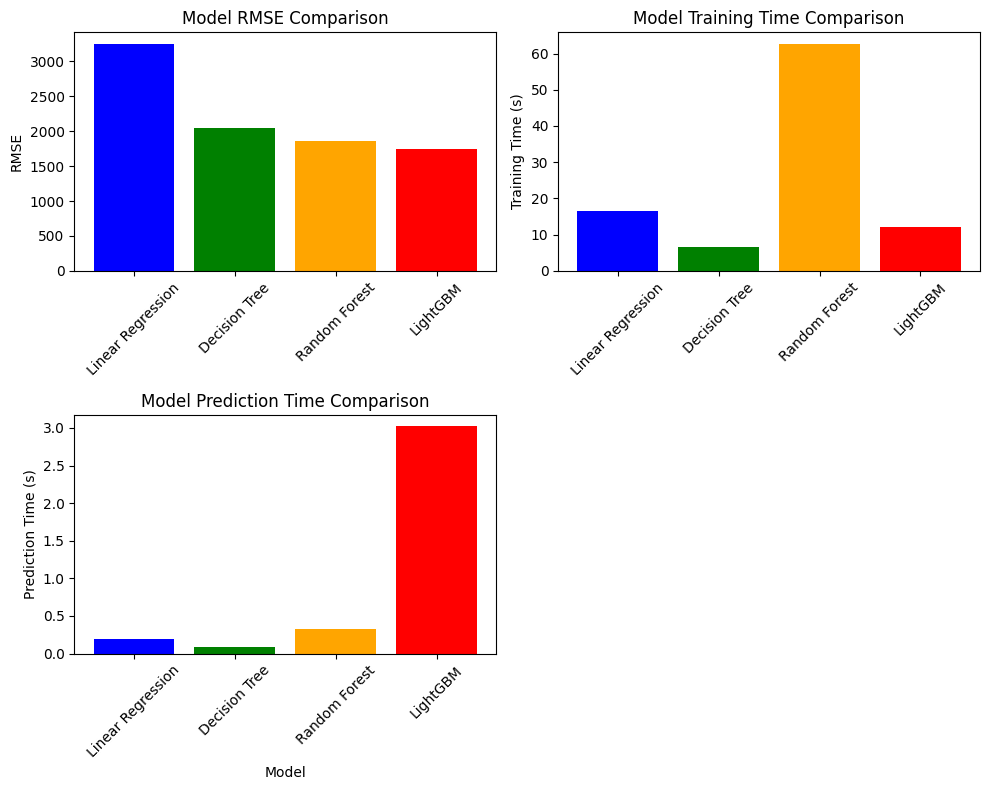

In [85]:
# Compare RMSE, Train and Predict Values

fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 

# RMSE comparison
axes[0, 0].bar(rmse_values.keys(), rmse_values.values(), color=['blue', 'green', 'orange', 'red'])
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Model RMSE Comparison')
axes[0, 0].tick_params(axis='x', rotation=45) 

# Train Time comparison
axes[0, 1].bar(training_times.keys(), training_times.values(), color=['blue', 'green', 'orange', 'red'])
axes[0, 1].set_ylabel('Training Time (s)')
axes[0, 1].set_title('Model Training Time Comparison')
axes[0, 1].tick_params(axis='x', rotation=45) 

# Prediction Time comparison
axes[1, 0].bar(prediction_times.keys(), prediction_times.values(), color=['blue', 'green', 'orange', 'red'])
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Prediction Time (s)')
axes[1, 0].set_title('Model Prediction Time Comparison')
axes[1, 0].tick_params(axis='x', rotation=45)

# Hide the empty subplot at bottom-right corner
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

**Findings**

Each model exhibits distinct capabilities and constraints. Upon training each model with its optimal parameters and evaluating them with test data, the results reflected patterns observed during training. Specifically, the Light GBM model achieved a lower RMSE score when trained with its optimal hyperparameters. In terms of training speed, the Light GBM model ranked second, just behind the decision tree regressor, which was notably faster than the Random Forest Regressor, despite the latter achieving the second lowest RMSE score. However, the prediction time for the Light GBM model was slightly slower compared to the other models, albeit by a marginal difference.

## Conclusion

The integration of LightGBM into the Rusty Bargain app's framework marks a significant enhancement in predictive accuracy and speed for vehicle valuations. LightGBM has proven its superiority over other models by effectively minimizing RMSE, thereby ensuring precise valuations that users can rely on.

One of the key advantages of LightGBM lies in its ability to deliver fast predictions without compromising accuracy. This efficiency is crucial for maintaining a seamless user experience, allowing Rusty Bargain app users to receive prompt and reliable valuations based on comprehensive data and specifications.

The decision to adopt LightGBM underscores a strategic approach aimed at leveraging advanced machine learning techniques to enhance the app's capabilities. By optimizing both prediction accuracy and speed, Rusty Bargain ensures that its users benefit from dependable and efficient vehicle valuations, setting a new standard in the industry.